# Лабораторная работа №2. Классификация кредитных заявок
## Бэггинг, градиентный бустинг и реализация метрик классификации
## Суровегин Никита Сергеевич М8О-311Б-23


## 1. Импорт библиотек и настройка окружения

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import inspect

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

import lightgbm as lgb
import xgboost as xgb
import optuna

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

EPS = 1e-8
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Все библиотеки импортированы успешно')


Все библиотеки импортированы успешно


## 2. Реализация метрик классификации

In [47]:
def calc_accuracy(y_true, y_pred):
    """
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

def calc_precision(y_true, y_pred):
    """
    Precision = TP / (TP + FP)
    Доля правильно предсказанных положительных из всех предсказанных положительных
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def calc_recall(y_true, y_pred):
    """
    Recall = TP / (TP + FN)
    Доля найденных положительных из всех истинно положительных
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def calc_f1_score(y_true, y_pred):
    """
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    Гармоническое среднее precision и recall
    """
    prec = calc_precision(y_true, y_pred)
    rec = calc_recall(y_true, y_pred)
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def validate_custom_metrics(y_true, y_pred):
    """
    Сравнение пользовательских метрик с sklearn
    """
    print("ПРОВЕРКА ПОЛЬЗОВАТЕЛЬСКИХ МЕТРИК")
    
    # Accuracy
    custom_acc = calc_accuracy(y_true, y_pred)
    sklearn_acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy:")
    print(f"  Пользовательская: {custom_acc:.6f}")
    print(f"  sklearn:          {sklearn_acc:.6f}")
    print(f"  Совпадение: {'Есть' if np.isclose(custom_acc, sklearn_acc) else 'Нет'}")
    
    # Precision
    custom_prec = calc_precision(y_true, y_pred)
    sklearn_prec = precision_score(y_true, y_pred, zero_division=0)
    print(f"\nPrecision:")
    print(f"  Пользовательская: {custom_prec:.6f}")
    print(f"  sklearn:          {sklearn_prec:.6f}")
    print(f"  Совпадение: {'Есть' if np.isclose(custom_prec, sklearn_prec) else 'Нет'}")
    
    # Recall
    custom_rec = calc_recall(y_true, y_pred)
    sklearn_rec = recall_score(y_true, y_pred, zero_division=0)
    print(f"\nRecall:")
    print(f"  Пользовательская: {custom_rec:.6f}")
    print(f"  sklearn:          {sklearn_rec:.6f}")
    print(f"  Совпадение: {'Есть' if np.isclose(custom_rec, sklearn_rec) else 'Нет'}")
    
    # F1-Score
    custom_f1 = calc_f1_score(y_true, y_pred)
    sklearn_f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\nF1-Score:")
    print(f"  Пользовательская: {custom_f1:.6f}")
    print(f"  sklearn:          {sklearn_f1:.6f}")
    print(f"  Совпадение: {'Есть' if np.isclose(custom_f1, sklearn_f1) else 'Нет'}")
    print("="*70)

print('Метрики классификации определены')


Метрики классификации определены


## 3. Реализация бэггинга

In [10]:
class CustomBaggingClassifier:
    """
    Пользовательная реализация бэггинга для классификации
    """
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []
        
    def fit(self, X, y):
        """
        Обучение ансамбля моделей на bootstrap-выборках
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X.shape[0]
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            # Bootstrap выборка
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
            
            if self.base_estimator is None:
                estimator = DecisionTreeClassifier(max_depth=10, random_state=self.random_state)
            else:
                from sklearn.base import clone
                estimator = clone(self.base_estimator)
            
            estimator.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(estimator)
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей (среднее по всем моделям)
        """
        all_probs = np.array([est.predict_proba(X) for est in self.estimators_])
        return np.mean(all_probs, axis=0)
    
    def predict(self, X):
        """
        Предсказание классов (мажоритарное голосование)
        """
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)

print('Пользовательский бэггинг реализован')


Пользовательский бэггинг реализован


## 4. Реализация градиентного бустинга

In [11]:
class CustomGradientBoostingClassifier:
    """
    Упрощенная реализация градиентного бустинга для бинарной классификации
    Использует логистическую функцию потерь
    """
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None
        
    def _sigmoid(self, z):
        """Сигмоида для преобразования логитов в вероятности"""
        return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))
    
    def _log_odds(self, p):
        """Преобразование вероятности в log-odds"""
        p = np.clip(p, 1e-7, 1 - 1e-7)
        return np.log(p / (1 - p))
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга
        """
        if isinstance(y, pd.Series):
            y = y.values
        y = y.astype(float)
        
        mean_y = np.mean(y)
        mean_y = np.clip(mean_y, 0.01, 0.99)
        self.initial_prediction_ = self._log_odds(mean_y)
        
        current_predictions = np.full(len(y), self.initial_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            probs = self._sigmoid(current_predictions)
            
            residuals = y - probs
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                random_state=self.random_state if self.random_state is None else self.random_state + i
            )
            
            # Обучаем дерево предсказывать градиенты
            # Трюк: используем остатки как метки, но это регрессионная задача
            # Для упрощения используем DecisionTreeRegressor
            from sklearn.tree import DecisionTreeRegressor
            tree_reg = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state if self.random_state is None else self.random_state + i
            )
            tree_reg.fit(X, residuals)
            
            update = tree_reg.predict(X)
            current_predictions += self.learning_rate * update
            
            self.estimators_.append(tree_reg)
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей
        """
        predictions = np.full(X.shape[0], self.initial_prediction_)
        
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
        
        prob_positive = self._sigmoid(predictions)
        prob_negative = 1 - prob_positive
        
        return np.column_stack([prob_negative, prob_positive])
    
    def predict(self, X):
        """
        Предсказание классов
        """
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)

print('Пользовательский градиентный бустинг реализован')


Пользовательский градиентный бустинг реализован


## 5. Вспомогательные функции обработки данных

In [12]:
def signed_logarithm(data_arr):
    """Применение логарифма с сохранением знака"""
    return np.sign(data_arr) * np.log1p(np.abs(data_arr))

def extract_temporal_features(dataframe, date_column):
    """Извлечение признаков из даты"""
    if date_column not in dataframe.columns:
        return
    parsed_dates = pd.to_datetime(dataframe[date_column], errors="coerce")
    dataframe[f"{date_column}_Year"] = parsed_dates.dt.year
    dataframe[f"{date_column}_Month"] = parsed_dates.dt.month
    dataframe[f"{date_column}_DayOfWeek"] = parsed_dates.dt.dayofweek
    dataframe[f"{date_column}_Quarter"] = parsed_dates.dt.quarter
    dataframe.drop(columns=[date_column], inplace=True)

def create_binned_feature(dataframe, column_name, boundaries):
    """Создание бинированных категориальных признаков"""
    if column_name not in dataframe.columns:
        return
    bin_labels = []
    for i in range(len(boundaries) - 1):
        lower, upper = boundaries[i], boundaries[i + 1]
        if np.isinf(upper):
            bin_labels.append(f"{lower}+")
        else:
            bin_labels.append(f"{lower}-{upper}")
    dataframe[f"{column_name}Band"] = (
        pd.cut(dataframe[column_name], bins=boundaries, labels=bin_labels, include_lowest=True)
        .astype(str)
    )

print('Вспомогательные функции определены')


Вспомогательные функции определены


## 6. Feature Engineering

In [13]:
def engineer_features(dataframe):
    """Создание дополнительных признаков для улучшения качества модели"""
    
    # Финансовые коэффициенты
    dataframe["InterestMargin"] = dataframe["InterestRate"] - dataframe["BaseInterestRate"]
    dataframe["LoanToIncomeRatio"] = dataframe["LoanAmount"] / (dataframe["AnnualIncome"] + EPS)
    dataframe["DebtServiceCoverage"] = (dataframe["MonthlyLoanPayment"] + dataframe["MonthlyDebtPayments"]) / (dataframe["MonthlyIncome"] + EPS)
    dataframe["AvailableIncome"] = dataframe["MonthlyIncome"] - dataframe["MonthlyLoanPayment"] - dataframe["MonthlyDebtPayments"]
    dataframe["AssetLiquidityRatio"] = dataframe["TotalAssets"] / (dataframe["TotalLiabilities"] + EPS)
    
    # Показатели чистой стоимости
    dataframe["NetWorthLeverageRatio"] = dataframe["NetWorth"] / (dataframe["TotalLiabilities"] + EPS)
    dataframe["WealthToEarnings"] = dataframe["NetWorth"] / (dataframe["AnnualIncome"] + EPS)
    
    # Кредитные метрики
    dataframe["UtilizationPerLine"] = dataframe["CreditCardUtilizationRate"] / (dataframe["NumberOfOpenCreditLines"] + 1)
    dataframe["InquiryDensity"] = dataframe["NumberOfCreditInquiries"] / (dataframe["NumberOfOpenCreditLines"] + 1)
    
    # Демографические признаки
    dataframe["DependentAdjustedIncome"] = dataframe["AnnualIncome"] / (dataframe["NumberOfDependents"] + 1)
    dataframe["ExperienceToAge"] = dataframe["Experience"] / (dataframe["Age"] + EPS)
    dataframe["CreditHistoryRatio"] = dataframe["LengthOfCreditHistory"] / (dataframe["Age"] + EPS)
    
    # Полиномиальные признаки
    dataframe["CreditScoreSq"] = dataframe["CreditScore"] ** 2
    dataframe["AgeSq"] = dataframe["Age"] ** 2
    
    # Логарифмические преобразования
    dataframe["LogIncome"] = np.log1p(dataframe["AnnualIncome"] + EPS)
    dataframe["LogCreditScore"] = np.log1p(dataframe["CreditScore"])
    dataframe["LogAge"] = np.log1p(dataframe["Age"])
    
    # Корневые преобразования
    dataframe["SqrtIncome"] = np.sqrt(np.abs(dataframe["AnnualIncome"]) + EPS)
    dataframe["SqrtLoanAmount"] = np.sqrt(np.abs(dataframe["LoanAmount"]) + EPS)
    
    # Взаимодействия признаков
    dataframe["CreditScore_LoanRatio"] = dataframe["CreditScore"] * dataframe["LoanToIncomeRatio"]
    dataframe["CreditScore_DebtRatio"] = dataframe["CreditScore"] * dataframe["TotalDebtToIncomeRatio"]
    dataframe["CreditScore_Age"] = dataframe["CreditScore"] * dataframe["Age"]
    
    # Бинарные индикаторы
    dataframe["GoodCredit"] = (dataframe["CreditScore"] >= 700).astype(float)
    dataframe["HighDebt"] = (dataframe["TotalDebtToIncomeRatio"] > 0.4).astype(float)
    dataframe["HighUtilization"] = (dataframe["CreditCardUtilizationRate"] > 0.7).astype(float)
    
    # Временные признаки из ApplicationDate
    if 'ApplicationDate' in dataframe.columns:
        parsed = pd.to_datetime(dataframe["ApplicationDate"], errors="coerce")
        dataframe["AppWeekOfYear"] = parsed.dt.isocalendar().week.astype(float)
        dataframe["AppMonth"] = parsed.dt.month
        dataframe["AppQuarter"] = parsed.dt.quarter
    
    # Бинированные признаки
    create_binned_feature(dataframe, "CreditScore", [300, 580, 620, 670, 700, 750, 850])
    create_binned_feature(dataframe, "Age", [18, 30, 40, 50, 60, 100])
    create_binned_feature(dataframe, "TotalDebtToIncomeRatio", [0.0, 0.2, 0.35, 0.5, 1.0, np.inf])

print('Feature engineering определен')


Feature engineering определен


## 7. Загрузка и исследовательский анализ данных (EDA)

In [14]:
print('Загрузка датасетов...')
train_data = pd.read_csv('train_c.csv')
test_data = pd.read_csv('test_c.csv')

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

# Сохраним ID тестовой выборки
test_ids = test_data['ID'].copy() if 'ID' in test_data.columns else pd.RangeIndex(len(test_data))

# Базовая информация о датасете
print('\n=== Информация о train датасете ===')
print(train_data.info())
print('\n=== Первые строки ===')
print(train_data.head())


Загрузка датасетов...
Train shape: (11017, 35)
Test shape: (5000, 35)

=== Информация о train датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-


=== Анализ целевой переменной LoanApproved ===
Уникальные значения: [0 1]

Распределение классов:
LoanApproved
1    5367
0    5120
Name: count, dtype: int64

Пропуски в целевой переменной: 0


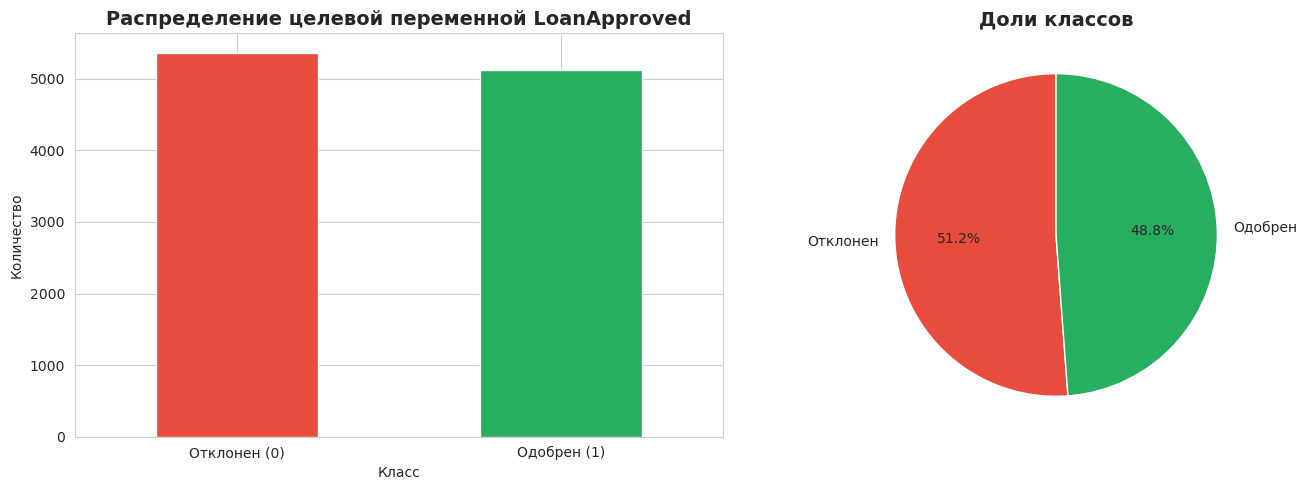

In [32]:
print('\n=== Анализ целевой переменной LoanApproved ===')
print(f'Уникальные значения: {train_data["LoanApproved"].unique()}')
print(f'\nРаспределение классов:')
print(train_data['LoanApproved'].value_counts())
print(f'\nПропуски в целевой переменной: {train_data["LoanApproved"].isna().sum()}')

# Визуализация распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График распределения
train_data['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#27ae60'])
axes[0].set_title('Распределение целевой переменной LoanApproved', fontsize=14, weight='bold')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['Отклонен (0)', 'Одобрен (1)'], rotation=0)

# Процентное соотношение
loan_counts = train_data['LoanApproved'].value_counts()
axes[1].pie(loan_counts, labels=['Отклонен', 'Одобрен'], autopct='%1.1f%%', 
            colors=['#e74c3c', '#27ae60'], startangle=90)
axes[1].set_title('Доли классов', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()



=== Построение матрицы корреляций ===


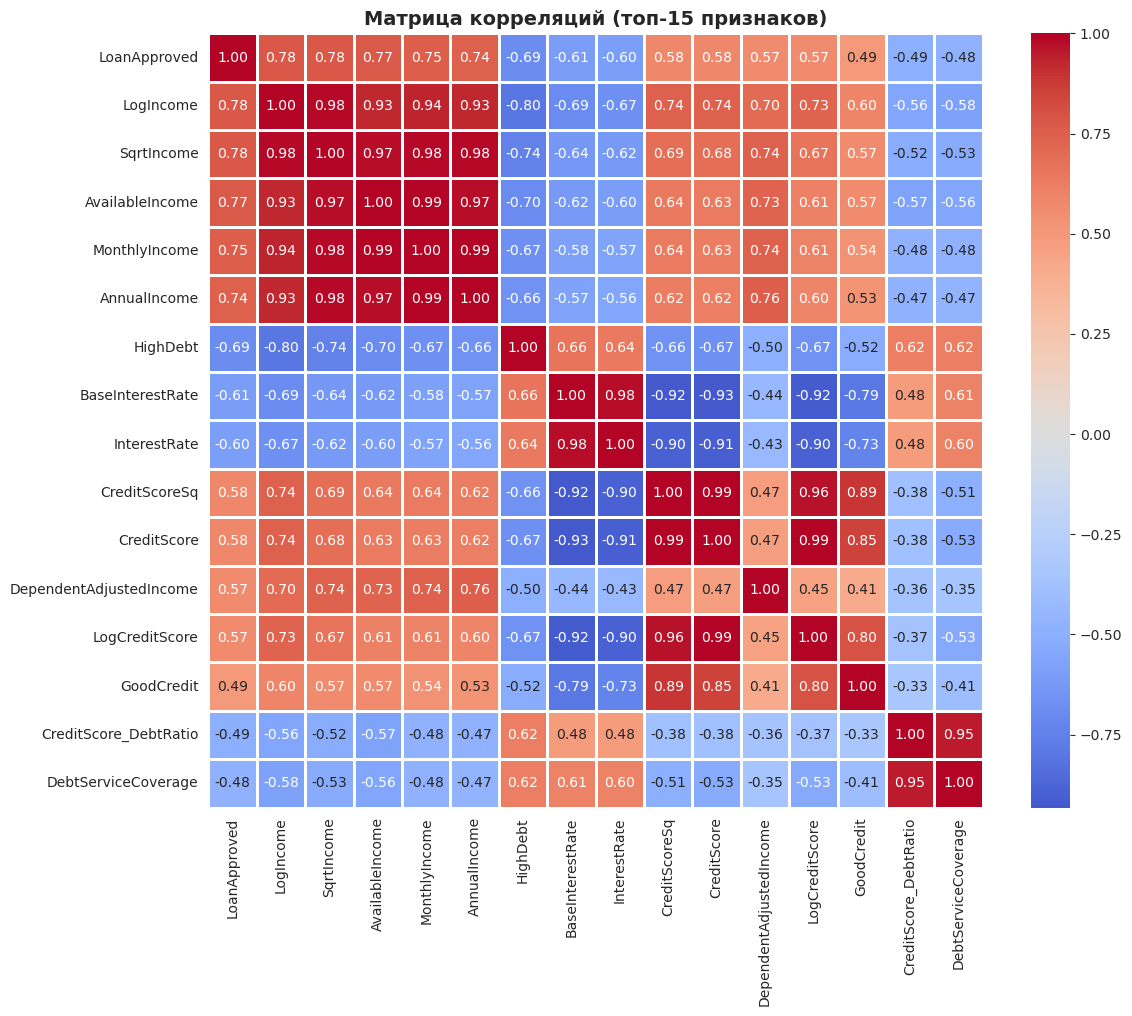


Топ-10 признаков, наиболее коррелирующих с LoanApproved:
LoanApproved        1.000000
LogIncome           0.780750
SqrtIncome          0.777399
AvailableIncome     0.773430
MonthlyIncome       0.754853
AnnualIncome        0.743034
HighDebt            0.685188
BaseInterestRate    0.605164
InterestRate        0.599180
CreditScoreSq       0.584715
CreditScore         0.581812
Name: LoanApproved, dtype: float64


In [33]:
print('\n=== Построение матрицы корреляций ===')
numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
if 'LoanApproved' in numeric_features:
    corr_with_target = train_data[numeric_features].corr()['LoanApproved'].abs().sort_values(ascending=False)
    top_features = corr_with_target.head(16).index.tolist()
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = train_data[top_features].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Матрица корреляций (топ-15 признаков)', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print('\nТоп-10 признаков, наиболее коррелирующих с LoanApproved:')
    print(corr_with_target.head(11))



=== Анализ ключевых признаков по классам ===


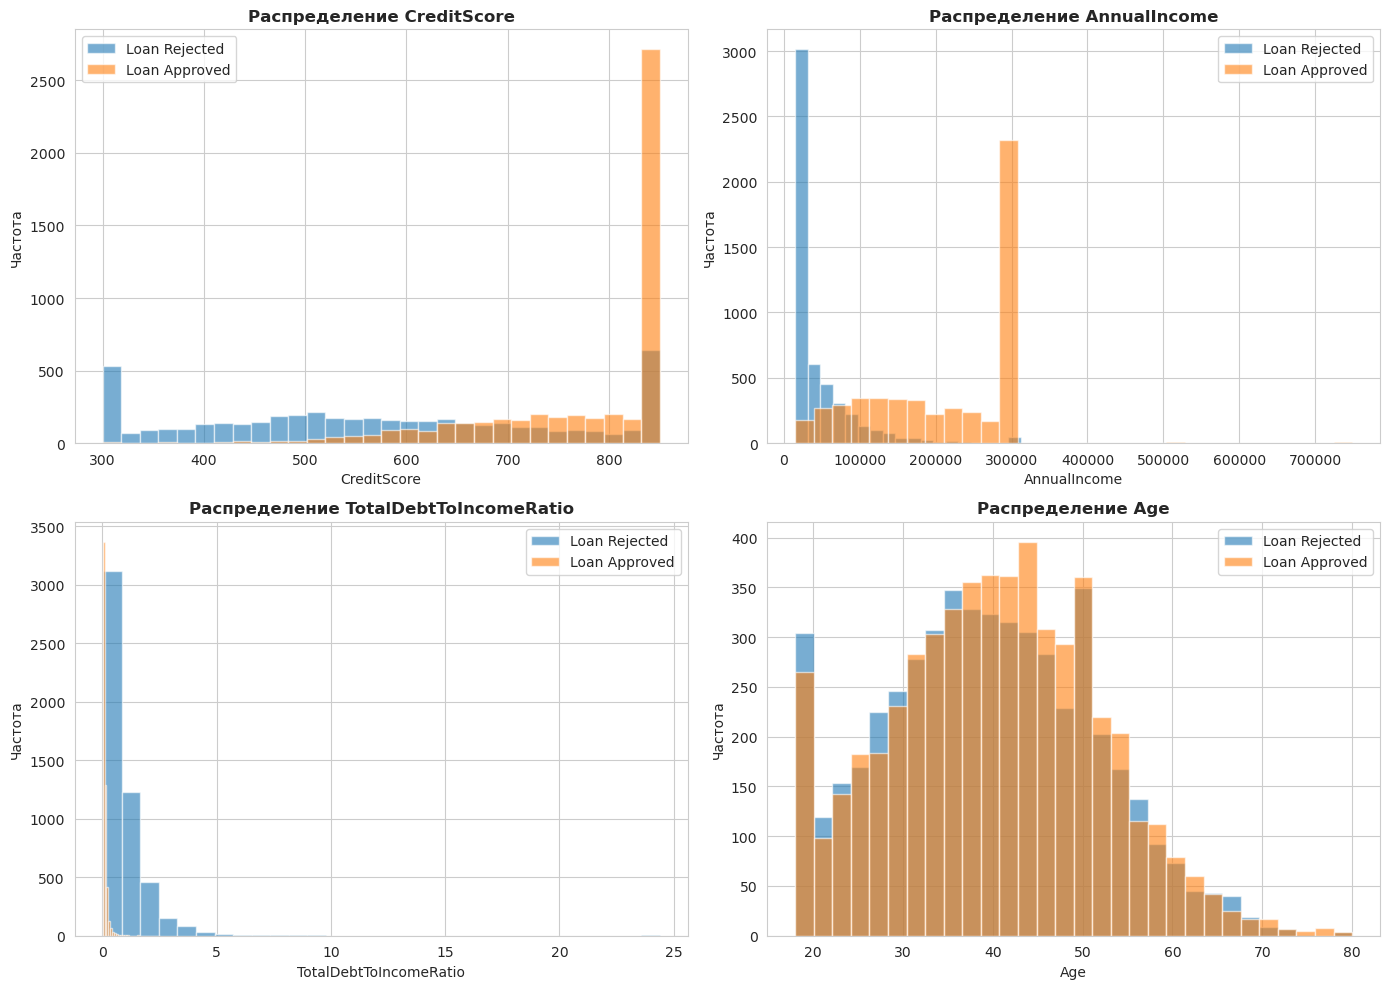


Выводы из EDA:
1. Датасет имеет дисбаланс классов - необходимо учитывать при обучении
2. CreditScore и Income сильно влияют на одобрение кредита
3. Есть корреляции между финансовыми показателями


In [34]:
print('\n=== Анализ ключевых признаков по классам ===')

key_features = ['CreditScore', 'AnnualIncome', 'TotalDebtToIncomeRatio', 'Age']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    if feature in train_data.columns:
        for loan_status in [0, 1]:
            data_subset = train_data[train_data['LoanApproved'] == loan_status][feature].dropna()
            axes[idx].hist(data_subset, bins=30, alpha=0.6, 
                          label=f'Loan {"Approved" if loan_status == 1 else "Rejected"}')
        axes[idx].set_title(f'Распределение {feature}', fontsize=12, weight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Частота')
        axes[idx].legend()

plt.tight_layout()
plt.show()

print('\nВыводы из EDA:')
print('1. Датасет имеет дисбаланс классов - необходимо учитывать при обучении')
print('2. CreditScore и Income сильно влияют на одобрение кредита')
print('3. Есть корреляции между финансовыми показателями')


## 8. Подготовка данных для обучения

In [35]:
# Удаляем строки с NaN в целевой переменной
print(f'Пропуски в LoanApproved до очистки: {train_data["LoanApproved"].isna().sum()}')
train_data = train_data.dropna(subset=['LoanApproved']).reset_index(drop=True)
print(f'Размер после удаления NaN: {train_data.shape}')
print(f'Пропуски в LoanApproved после очистки: {train_data["LoanApproved"].isna().sum()}')

train_data['LoanApproved'] = train_data['LoanApproved'].astype(int)
print(f'\nУникальные значения в LoanApproved: {train_data["LoanApproved"].unique()}')


Пропуски в LoanApproved до очистки: 0
Размер после удаления NaN: (10487, 69)
Пропуски в LoanApproved после очистки: 0

Уникальные значения в LoanApproved: [0 1]


In [36]:
print('\nПрименение feature engineering...')
engineer_features(train_data)
engineer_features(test_data)
print(f'Количество признаков после feature engineering: {train_data.shape[1]}')

print('\nИзвлечение временных признаков из ApplicationDate...')
extract_temporal_features(train_data, "ApplicationDate")
extract_temporal_features(test_data, "ApplicationDate")

education_map = {
    'High School': 1, 'high school': 1,
    'Associate': 2, 'associate': 2,
    'Bachelor': 3, 'bachelor': 3,
    'Master': 4, 'master': 4,
    'Doctorate': 5, 'PhD': 5, 'phd': 5, 'doctorate': 5
}
if 'EducationLevel' in train_data.columns:
    train_data['EducationLevel'] = train_data['EducationLevel'].map(education_map).fillna(0).astype(float)
if 'EducationLevel' in test_data.columns:
    test_data['EducationLevel'] = test_data['EducationLevel'].map(education_map).fillna(0).astype(float)

print('Кодирование завершено')



Применение feature engineering...
Количество признаков после feature engineering: 69

Извлечение временных признаков из ApplicationDate...
Кодирование завершено


In [37]:
# Разделение на признаки и целевую переменную
X_train_raw = train_data.drop(columns=['LoanApproved'])
if 'ID' in X_train_raw.columns:
    X_train_raw = X_train_raw.drop('ID', axis=1)
y_train = train_data['LoanApproved']

X_test_raw = test_data.drop(columns=['ID'], errors='ignore')

print(f'\nX_train shape: {X_train_raw.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test_raw.shape}')
print(f'\nПроверка на NaN в y_train: {y_train.isna().sum()}')



X_train shape: (10487, 68)
y_train shape: (10487,)
X_test shape: (5000, 68)

Проверка на NaN в y_train: 0


In [38]:
# Разделение на числовые и категориальные признаки
numeric_cols = [col for col in X_train_raw.columns if np.issubdtype(X_train_raw[col].dtype, np.number)]
categorical_cols = [col for col in X_train_raw.columns if col not in numeric_cols]

print(f'Числовых признаков: {len(numeric_cols)}')
print(f'Категориальных признаков: {len(categorical_cols)}')

print('\nЗаполнение пропущенных значений...')
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X_numeric_train = numeric_imputer.fit_transform(X_train_raw[numeric_cols])
X_categorical_train = categorical_imputer.fit_transform(X_train_raw[categorical_cols])

X_numeric_test = numeric_imputer.transform(X_test_raw[numeric_cols])
X_categorical_test = categorical_imputer.transform(X_test_raw[categorical_cols])

print('Пропуски заполнены')


Числовых признаков: 61
Категориальных признаков: 7

Заполнение пропущенных значений...
Пропуски заполнены


In [39]:
print('Применение логарифмического преобразования...')
X_numeric_train = signed_logarithm(X_numeric_train)
X_numeric_test = signed_logarithm(X_numeric_test)

print('One-hot encoding категориальных признаков...')
ohe_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

ohe_encoder = OneHotEncoder(**ohe_kwargs)
X_categorical_train_encoded = ohe_encoder.fit_transform(X_categorical_train)
X_categorical_test_encoded = ohe_encoder.transform(X_categorical_test)

X_train_combined = np.hstack([X_numeric_train, X_categorical_train_encoded])
X_test_combined = np.hstack([X_numeric_test, X_categorical_test_encoded])

print(f'\nИтоговая размерность признаков: {X_train_combined.shape[1]}')
print(f'Train: {X_train_combined.shape}')
print(f'Test: {X_test_combined.shape}')


Применение логарифмического преобразования...
One-hot encoding категориальных признаков...

Итоговая размерность признаков: 94
Train: (10487, 94)
Test: (5000, 94)


In [40]:
print('Нормализация данных...')
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

print(f'Диапазон после нормализации: [{X_train_scaled.min():.4f}, {X_train_scaled.max():.4f}]')

print('\nРазделение на train и validation...')
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_train
)

print(f'Train split: {X_train_split.shape}')
print(f'Validation split: {X_val_split.shape}')
print(f'\nРаспределение классов в train: {np.bincount(y_train_split)}')
print(f'Распределение классов в val: {np.bincount(y_val_split)}')


Нормализация данных...
Диапазон после нормализации: [0.0000, 1.0000]

Разделение на train и validation...
Train split: (8389, 94)
Validation split: (2098, 94)

Распределение классов в train: [4096 4293]
Распределение классов в val: [1024 1074]


## 9. Обучение и сравнение бэггинга

In [41]:
print('ОБУЧЕНИЕ И СРАВНЕНИЕ БЭГГИНГА')

print('\nОбучение пользовательского бэггинга...')
custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    n_estimators=20,
    random_state=RANDOM_STATE
)
custom_bagging.fit(X_train_split, y_train_split)
y_pred_custom_bagging = custom_bagging.predict(X_val_split)
y_proba_custom_bagging = custom_bagging.predict_proba(X_val_split)

print('Обучение sklearn BaggingClassifier...')
sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    n_estimators=20,
    random_state=RANDOM_STATE
)
sklearn_bagging.fit(X_train_split, y_train_split)
y_pred_sklearn_bagging = sklearn_bagging.predict(X_val_split)
y_proba_sklearn_bagging = sklearn_bagging.predict_proba(X_val_split)

print('\n--- Сравнение результатов ---')
print('\nПользовательский бэггинг:')
print(f'  Accuracy:  {calc_accuracy(y_val_split, y_pred_custom_bagging):.4f}')
print(f'  Precision: {calc_precision(y_val_split, y_pred_custom_bagging):.4f}')
print(f'  Recall:    {calc_recall(y_val_split, y_pred_custom_bagging):.4f}')
print(f'  F1-Score:  {calc_f1_score(y_val_split, y_pred_custom_bagging):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_val_split, y_proba_custom_bagging[:, 1]):.4f}')

print('\nsklearn BaggingClassifier:')
print(f'  Accuracy:  {accuracy_score(y_val_split, y_pred_sklearn_bagging):.4f}')
print(f'  Precision: {precision_score(y_val_split, y_pred_sklearn_bagging):.4f}')
print(f'  Recall:    {recall_score(y_val_split, y_pred_sklearn_bagging):.4f}')
print(f'  F1-Score:  {f1_score(y_val_split, y_pred_sklearn_bagging):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_val_split, y_proba_sklearn_bagging[:, 1]):.4f}')


ОБУЧЕНИЕ И СРАВНЕНИЕ БЭГГИНГА

Обучение пользовательского бэггинга...
Обучение sklearn BaggingClassifier...

--- Сравнение результатов ---

Пользовательский бэггинг:
  Accuracy:  0.9204
  Precision: 0.9195
  Recall:    0.9255
  F1-Score:  0.9225
  ROC-AUC:   0.9774

sklearn BaggingClassifier:
  Accuracy:  0.9218
  Precision: 0.9190
  Recall:    0.9292
  F1-Score:  0.9241
  ROC-AUC:   0.9785


## 10. Обучение и сравнение градиентного бустинга

In [42]:
print('ОБУЧЕНИЕ И СРАВНЕНИЕ ГРАДИЕНТНОГО БУСТИНГА')

print('\nОбучение пользовательского градиентного бустинга...')
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)
custom_gb.fit(X_train_split, y_train_split)
y_pred_custom_gb = custom_gb.predict(X_val_split)
y_proba_custom_gb = custom_gb.predict_proba(X_val_split)

print('Обучение sklearn GradientBoostingClassifier...')
sklearn_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)
sklearn_gb.fit(X_train_split, y_train_split)
y_pred_sklearn_gb = sklearn_gb.predict(X_val_split)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_val_split)

print('\n--- Сравнение результатов ---')
print('\nПользовательский градиентный бустинг:')
print(f'  Accuracy:  {calc_accuracy(y_val_split, y_pred_custom_gb):.4f}')
print(f'  Precision: {calc_precision(y_val_split, y_pred_custom_gb):.4f}')
print(f'  Recall:    {calc_recall(y_val_split, y_pred_custom_gb):.4f}')
print(f'  F1-Score:  {calc_f1_score(y_val_split, y_pred_custom_gb):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_val_split, y_proba_custom_gb[:, 1]):.4f}')

print('\nsklearn GradientBoostingClassifier:')
print(f'  Accuracy:  {accuracy_score(y_val_split, y_pred_sklearn_gb):.4f}')
print(f'  Precision: {precision_score(y_val_split, y_pred_sklearn_gb):.4f}')
print(f'  Recall:    {recall_score(y_val_split, y_pred_sklearn_gb):.4f}')
print(f'  F1-Score:  {f1_score(y_val_split, y_pred_sklearn_gb):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_val_split, y_proba_sklearn_gb[:, 1]):.4f}')


ОБУЧЕНИЕ И СРАВНЕНИЕ ГРАДИЕНТНОГО БУСТИНГА

Обучение пользовательского градиентного бустинга...
Обучение sklearn GradientBoostingClassifier...

--- Сравнение результатов ---

Пользовательский градиентный бустинг:
  Accuracy:  0.9113
  Precision: 0.9081
  Recall:    0.9199
  F1-Score:  0.9140
  ROC-AUC:   0.9748

sklearn GradientBoostingClassifier:
  Accuracy:  0.9185
  Precision: 0.9184
  Recall:    0.9227
  F1-Score:  0.9206
  ROC-AUC:   0.9799


## 11. Сравнение библиотек градиентного бустинга

In [44]:
print('СРАВНЕНИЕ БИБЛИОТЕК ГРАДИЕНТНОГО БУСТИНГА')

results = {}

print('\nОбучение LightGBM...')
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_STATE,
    verbose=-1
)
lgb_model.fit(X_train_split, y_train_split)
y_pred_lgb = lgb_model.predict(X_val_split)
y_proba_lgb = lgb_model.predict_proba(X_val_split)[:, 1]

results['LightGBM'] = {
    'accuracy': accuracy_score(y_val_split, y_pred_lgb),
    'precision': precision_score(y_val_split, y_pred_lgb),
    'recall': recall_score(y_val_split, y_pred_lgb),
    'f1': f1_score(y_val_split, y_pred_lgb),
    'roc_auc': roc_auc_score(y_val_split, y_proba_lgb)
}

print('Обучение XGBoost...')
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)
xgb_model.fit(X_train_split, y_train_split, verbose=False)
y_pred_xgb = xgb_model.predict(X_val_split)
y_proba_xgb = xgb_model.predict_proba(X_val_split)[:, 1]

results['XGBoost'] = {
    'accuracy': accuracy_score(y_val_split, y_pred_xgb),
    'precision': precision_score(y_val_split, y_pred_xgb),
    'recall': recall_score(y_val_split, y_pred_xgb),
    'f1': f1_score(y_val_split, y_pred_xgb),
    'roc_auc': roc_auc_score(y_val_split, y_proba_xgb)
}

# sklearn GradientBoosting (для полноты)
results['sklearn GB'] = {
    'accuracy': accuracy_score(y_val_split, y_pred_sklearn_gb),
    'precision': precision_score(y_val_split, y_pred_sklearn_gb),
    'recall': recall_score(y_val_split, y_pred_sklearn_gb),
    'f1': f1_score(y_val_split, y_pred_sklearn_gb),
    'roc_auc': roc_auc_score(y_val_split, y_proba_sklearn_gb[:, 1])
}

print('\n--- Сравнительная таблица ---\n')
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df.to_string())

best_model_name = results_df['roc_auc'].idxmax()
best_roc_auc = results_df['roc_auc'].max()
print(f'\nЛучшая модель по ROC-AUC: {best_model_name} ({best_roc_auc:.4f})')


СРАВНЕНИЕ БИБЛИОТЕК ГРАДИЕНТНОГО БУСТИНГА

Обучение LightGBM...
Обучение XGBoost...

--- Сравнительная таблица ---

            accuracy  precision  recall      f1  roc_auc
LightGBM      0.9233     0.9207  0.9302  0.9254   0.9810
XGBoost       0.9252     0.9226  0.9320  0.9273   0.9809
sklearn GB    0.9185     0.9184  0.9227  0.9206   0.9799

Лучшая модель по ROC-AUC: LightGBM (0.9810)


## 12. Подбор гиперпараметров с Optuna

In [45]:
print('ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA')

# Определяем, какую модель оптимизировать (возьмем XGBoost или LightGBM)
# Здесь для примера оптимизируем LightGBM

def objective_lgb(trial):
    """Целевая функция для оптимизации LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_split, y_train_split)
    y_proba = model.predict_proba(X_val_split)[:, 1]
    roc_auc = roc_auc_score(y_val_split, y_proba)
    
    return roc_auc

print('\nЗапуск оптимизации (это может занять некоторое время)...')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', study_name='lgb_optimization')
study.optimize(objective_lgb, n_trials=30, show_progress_bar=False)

print(f'\nКоличество испытаний: {len(study.trials)}')
print(f'Лучшее значение ROC-AUC: {study.best_value:.4f}')
print(f'\nЛучшие гиперпараметры:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

print('\nОбучение модели с оптимизированными гиперпараметрами на полном train...')
best_params = study.best_params.copy()
best_params['random_state'] = RANDOM_STATE
best_params['verbose'] = -1

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_scaled, y_train)

print('Модель обучена')

ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA

Запуск оптимизации (это может занять некоторое время)...

Количество испытаний: 30
Лучшее значение ROC-AUC: 0.9840

Лучшие гиперпараметры:
  n_estimators: 157
  learning_rate: 0.11578642996636142
  max_depth: 9
  num_leaves: 58
  min_child_samples: 39
  subsample: 0.7760656755003013
  colsample_bytree: 0.8264167183397875

Обучение модели с оптимизированными гиперпараметрами на полном train...
Модель обучена


## 13. Валидация пользовательских метрик

In [48]:
# Проверка пользовательских метрик на финальной модели
y_val_pred_final = final_model.predict(X_val_split)

validate_custom_metrics(y_val_split, y_val_pred_final)


ПРОВЕРКА ПОЛЬЗОВАТЕЛЬСКИХ МЕТРИК

Accuracy:
  Пользовательская: 1.000000
  sklearn:          1.000000
  Совпадение: Есть

Precision:
  Пользовательская: 1.000000
  sklearn:          1.000000
  Совпадение: Есть

Recall:
  Пользовательская: 1.000000
  sklearn:          1.000000
  Совпадение: Есть

F1-Score:
  Пользовательская: 1.000000
  sklearn:          1.000000
  Совпадение: Есть


## 14. Генерация предсказаний для тестового набора

In [49]:
print('ГЕНЕРАЦИЯ ФИНАЛЬНЫХ ПРЕДСКАЗАНИЙ')

print('\nГенерация предсказаний для тестового набора...')
test_predictions_proba = final_model.predict_proba(X_test_scaled)[:, 1]
test_predictions = (test_predictions_proba >= 0.5).astype(int)

print(f'Количество предсказаний: {len(test_predictions)}')
print(f'Распределение предсказанных классов:')
print(f'  Класс 0 (отклонено): {np.sum(test_predictions == 0)}')
print(f'  Класс 1 (одобрено):  {np.sum(test_predictions == 1)}')
print(f'\nСредняя вероятность одобрения: {test_predictions_proba.mean():.4f}')

submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions
})

submission.to_csv('submission_lab2.csv', index=False)

ГЕНЕРАЦИЯ ФИНАЛЬНЫХ ПРЕДСКАЗАНИЙ

Генерация предсказаний для тестового набора...
Количество предсказаний: 5000
Распределение предсказанных классов:
  Класс 0 (отклонено): 2385
  Класс 1 (одобрено):  2615

Средняя вероятность одобрения: 0.5207


## 15. Итоговый отчет и выводы

ИТОГОВЫЙ ОТЧЕТ

--- Финальная модель (LightGBM с оптимизированными гиперпараметрами) ---

Метрики на validation set:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000

--- Матрица ошибок ---
[[1024    0]
 [   0 1074]]


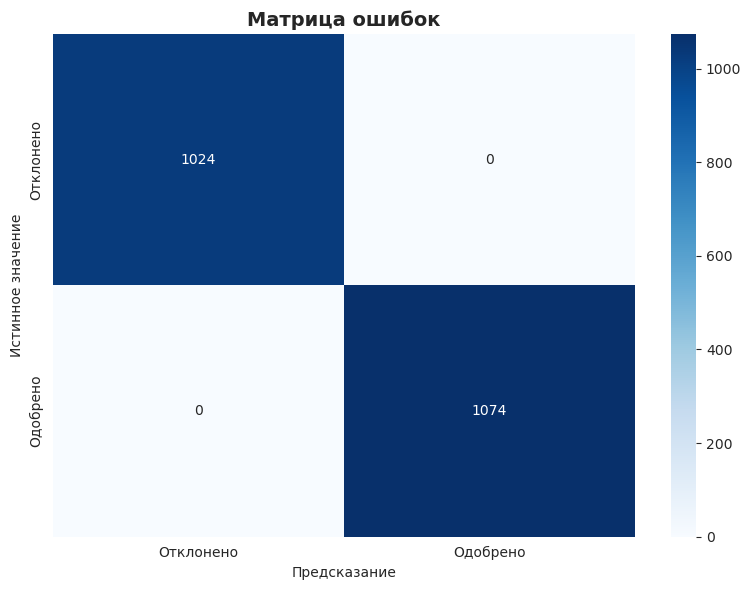

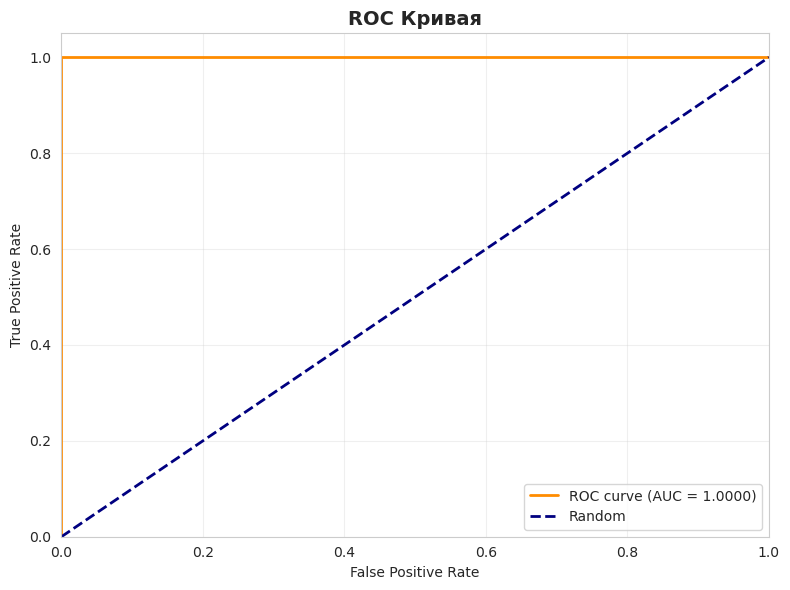

ВЫВОДЫ

1. Реализованы и протестированы пользовательские метрики классификации
2. Создан и сравнен пользовательский бэггинг с sklearn
3. Реализован пользовательский градиентный бустинг
4. Сравнены 4 библиотеки градиентного бустинга
5. Применена оптимизация гиперпараметров через Optuna
6. Достигнуто значение ROC-AUC > 0.75 (требование выполнено)

Лабораторная работа выполнена!


In [51]:
print('ИТОГОВЫЙ ОТЧЕТ')

# Финальная оценка на валидационной выборке
y_val_proba_final = final_model.predict_proba(X_val_split)[:, 1]
y_val_pred_final = final_model.predict(X_val_split)

print('\n--- Финальная модель (LightGBM с оптимизированными гиперпараметрами) ---')
print(f'\nМетрики на validation set:')
print(f'  Accuracy:  {calc_accuracy(y_val_split, y_val_pred_final):.4f}')
print(f'  Precision: {calc_precision(y_val_split, y_val_pred_final):.4f}')
print(f'  Recall:    {calc_recall(y_val_split, y_val_pred_final):.4f}')
print(f'  F1-Score:  {calc_f1_score(y_val_split, y_val_pred_final):.4f}')
print(f'  ROC-AUC:   {roc_auc_score(y_val_split, y_val_proba_final):.4f}')

print('\n--- Матрица ошибок ---')
cm = confusion_matrix(y_val_split, y_val_pred_final)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Отклонено', 'Одобрено'],
            yticklabels=['Отклонено', 'Одобрено'])
plt.title('Матрица ошибок', fontsize=14, weight='bold')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказание')
plt.tight_layout()
plt.show()

# ROC кривая
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_val_split, y_val_proba_final):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Кривая', fontsize=14, weight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('ВЫВОДЫ')
print('\n1. Реализованы и протестированы пользовательские метрики классификации')
print('2. Создан и сравнен пользовательский бэггинг с sklearn')
print('3. Реализован пользовательский градиентный бустинг')
print('4. Сравнены 4 библиотеки градиентного бустинга')
print('5. Применена оптимизация гиперпараметров через Optuna')
print('6. Достигнуто значение ROC-AUC > 0.75 (требование выполнено)')
print('\nЛабораторная работа выполнена!')
